In [83]:
import json
import os
import bz2
import io
from bz2 import BZ2File
import re
import numpy as np
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt



### Transform the data


The following command is here to throw useless datas in files. Since we already reduced the files, there is no need to do the compression again.

In [2]:
#! for f in data/*[0-9].jsonl.bz2; do bzcat $f | jq -c '{id: .id, type: .tp, date: .d, title: .t, fulltext: .ft}' | bzip2 > "{f%.jsonl.bz2}-reduced.jsonl.bz2" ; done

# Preparation

### List to see the data in data folder:

In [3]:
ls -la data/

total 718568
drwxr-xr-x  16 aslam  staff       512  6 mar 17:37 ./
drwxrwxrwx  46 aslam  staff      1472 13 mar 16:28 ../
-rw-r--r--@  1 aslam  staff      8196  6 mar 17:37 .DS_Store
-rwxrwxrwx   1 aslam  staff  23795907  3 mar 12:31 JDG-1980-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  21521939  3 mar 12:32 JDG-1981-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  22822888  3 mar 12:33 JDG-1982-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  25263118  3 mar 12:34 JDG-1983-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  23839962  3 mar 12:35 JDG-1984-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  22984620  3 mar 12:36 JDG-1985-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  33642024  3 mar 12:37 JDG-1986-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  29476045  3 mar 12:38 JDG-1987-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  33200405  3 mar 12:39 JDG-1988-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff  30297761  3 mar 12:40 JDG-1989-reduced.jsonl.bz2*
-rwxrwxrwx   1 aslam  staff

### Reading newspaper archive data

Reminder: the data is already 'clean' and the files at hand contains only the following information:
- id
- date
- title
- type (article or advertisement)
- fulltext


Since our reduced files are in data/, we need to have the path to them:

In [2]:
input_dir = "data/" # update with your path 

In [62]:
# a helper function to get the lines from am archive
def read_jsonlines(bz2_file):
    text = bz2_file.read().decode('utf-8')
    for line in text.split('\n'):
        if line != '':
            yield line

In [63]:
#gives in string all the dates between two dates
def string_dates(date1, date2):
    result = []
    delta = date2 - date1
    
    for i in range(delta.days + 1):
        result.append(str(d1+timedelta(i)))
        
    return result

In [64]:
# a helper function to see if we have all the keywords contained in a list
# returns true if all elements in arguments are positif
def all_pos(myList):
    return all(item > 0 for item in myList)


# return true if at least one element is positif
def one_pos(myList):
    for el in myList:
        if(el > 0):
            return True
    return False


# test 
# myList = [3, 2, 5, 2, 9]
#myList2 = [3, 2, 5, 2, 9, 0]
# all_pos(myList) # True
#all_pos(myList2) # False
# one_pos(myList2) # True

In [65]:
# this function deals with an article and return the occurences (sum for all the keywords given) --> or condition
# STAT PURPOSES
def study(article, keywords):
    json_article = json.loads(article)
    full_text_str = json_article["fulltext"]
    #full_text_str = article
    flag = False # this flag will be True if at least one of the keyword is in the text
    
    length = len(keywords)
    full_occurences = [0] * length
    
    for index in range(0, length):
        print("OCCURENCES: " + full_text_str[0:30])
        occurences = len(re.findall(keywords[index], full_text_str, re.IGNORECASE))
    
        #title = json_article["id"].encode('ascii','ignore')

        if(occurences > 0):
            flag = True
            full_occurences[index] = occurences
            
    #if flag:
            #print_arrays(title, keywords, full_occurences)
            # Instead of print_arrays, we should call a function that will decide if all content are good or not
            # a similar function will return sum of list (one "or" condition, and the and the "and" condition will be checked with all_pos)
    return sum(full_occurences)




In [9]:
print("NUMBER OF ARTICLES PER ARCHIVE")
for archive in os.listdir(input_dir):
    if("JDG" in archive):
        # print(archive)
        f = BZ2File(os.path.join(input_dir, archive), 'r')
        articles = list(read_jsonlines(f))

        print(archive + ", number of articles: " + str(len(articles)))

NUMBER OF ARTICLES PER ARCHIVE
JDG-1982-reduced.jsonl.bz2, number of articles: 28867
JDG-1987-reduced.jsonl.bz2, number of articles: 36041
JDG-1983-reduced.jsonl.bz2, number of articles: 27750
JDG-1986-reduced.jsonl.bz2, number of articles: 33499
JDG-1980-reduced.jsonl.bz2, number of articles: 27425
JDG-1985-reduced.jsonl.bz2, number of articles: 30169
JDG-1981-reduced.jsonl.bz2, number of articles: 27082
JDG-1984-reduced.jsonl.bz2, number of articles: 29819
JDG-1991-reduced.jsonl.bz2, number of articles: 40248
JDG-1988-reduced.jsonl.bz2, number of articles: 35745
JDG-1990-reduced.jsonl.bz2, number of articles: 35846
JDG-1989-reduced.jsonl.bz2, number of articles: 36879
JDG-1992-reduced.jsonl.bz2, number of articles: 39047


### Is an article valid?

The following function will check the validity of an article.
It returns true or false depending on if we keep the article:

Condition to drop an article:
- if title contains "BOURSE" or "TÉLÉVISION"

In [66]:
def isValid(json_article):
    if(json_article["title"] == None):
        return True
    elif("BOURSE" in json_article["title"]):
        return False
    elif("TÉLÉVISION" in json_article["fulltext"]):
        return False
    else:
        return True

In [67]:
# This function takes keywords in entry and return the articles and the occurences that contains them depending on isSelected conditions
def read_archive(keywords):
    selected_articles = []
    ALLOCC = []
    article_per_year_occ = [] # contains the number of article per year
    for archive in os.listdir(input_dir):
        # if a JDG archive
        if("JDG" in archive):
            print(archive)
            # we open the file
            f = BZ2File(os.path.join(input_dir, archive), 'r')
            # extraction of articles
            articles = list(read_jsonlines(f))
            occALLArticleOneArchive = np.asarray([0] * len(keywords))
            article_per_year = []
            for article in articles:
                # jsonify the article
                json_article = json.loads(article)
                # check if valid article
                if(isValid(json_article)):
                    selected, occurences = isSelected(json_article, keywords)
                    
                    if(selected):
                        # append to the return articles
                        selected_articles.append(article)
                        # append to compute the number of article per year
                        article_per_year.append(article)
                        # add the occurences
                        occALLArticleOneArchive += occurences
            article_per_year_occ.append(len(article_per_year))
            ALLOCC.append(occALLArticleOneArchive)
                            #print("article: " + json_article["id"] + " " + str(occArticle))
                      
            #print("archive " + archive  +  " contient: " + str(occALLArticleOneArchive))
    print("occurences per year (order see dates):" + str(article_per_year_occ))    
    return selected_articles, np.asarray(ALLOCC), article_per_year_occ
                
#mesArticles, occ = read_archive(["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"])
#print(len(mesArticles))
#print(occ)

In [68]:
# dates globales
d1 = date(1985, 11, 13)
d2 = date(1985, 11, 25)
datesCorpus6bis = string_dates(d1, d2)


d1 = date(1987, 12, 2)
d2 = date(1987, 12, 14)
# dates = ["1987-12-02", "1987-12-14"]
datesCorpus7bis = string_dates(d1, d2)


In [69]:
# isSelected takes an article and keywords: 
# we define here the conditions (and or or) on keywords in this function
# return True if an article is accepted
def isSelected(json_article, keywords):
    occArticle = np.asarray([0] * len(keywords))
    for keyword_index in range(0, len(keywords)): # we need the index later
        keyword = keywords[keyword_index]
        occArticle[keyword_index] = len(re.findall(keyword, json_article["fulltext"], re.IGNORECASE))
    
    selectedFlag = False
    
    if(keywords == ["Reagan", "Gorbatchev"]):
        selectedFlag = all_pos(occArticle)
    elif (keywords == ["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"]):
        # ici pas all_pos, mais plutot étudier si la somme de chaque cercle est > 0
        if(one_pos(occArticle[0:1+1]) or (one_pos(occArticle[2:5+1]) and one_pos(occArticle[6:10+1]))):
            selectedFlag = True
    elif (keywords == ["Reagan", "Etats-Unis", "USA ", "Amerique", "Washington", "politique", "économie", "pershing"]):
        if(one_pos([occArticle[0]]) or (one_pos(occArticle[1:4+1]) and one_pos(occArticle[5:7+1]))):
            selectedFlag = True
    elif (keywords == ["Sommet", "Genève", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        if(all_pos(occArticle[0:1+1]) or (all_pos(occArticle[0:1+1]) and (one_pos(occArticle[2:6+1])))):
            selectedFlag = True
        elif((one_pos(occArticle[2:6+1]))): # if Reagan gorbatchev/ov moscou or washington and in good dates:
            for date in datesCorpus6bis:
                infos = json_article["id"]
                if str(date) in infos:
                    selectedFlag = True
    elif (keywords == ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        if(all_pos(occArticle[0:1+1]) or (all_pos(occArticle[0:1+1]) and (one_pos(occArticle[2:6+1])))):
            selectedFlag = True
        elif((one_pos(occArticle[2:6+1]))): # if Reagan Gorbatchev/ov moscou or washington and in good dates:
            for date in datesCorpus7bis:
                infos = json_article["id"]
                if str(date) in infos:
                    selectedFlag = True
    elif (keywords == ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA ", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]):
        # reagan keys
        if(one_pos([occArticle[0]]) or (one_pos(occArticle[3:7]) and one_pos(occArticle[11:14]))):
            if(one_pos(occArticle[1:3]) or (one_pos(occArticle[7:11]) and one_pos(occArticle[14:18]))):
                selectedFlag = True
    
        #for index in range(len(keywords)):
            
    
    return selectedFlag, occArticle
    # occArticle contains number of iterations of all keywords
    
    # here rule depend on the keywords
        #if length > 0:
        #    occArticle += length
        #    occALLArticleOneArchive += occArticle

In [70]:
# This function take occurences, dates, keywords and a filename
# and plot the data and save the file
def plot_occurences(occ, keywords, dates, filename):
    df = pd.DataFrame(dict(zip(dates, occ)), index=keywords).T.sort_index()
    df.plot(kind="bar").legend()
    plt.savefig( filename + '.png')

In [71]:
def plot_nb_articles(occ, dates, filename):
    df = pd.DataFrame(occ, dates).sort_index()
    df.plot(kind="bar")
    plt.savefig( filename + '.png')

In [72]:
# Since it's not very visual to have graphs with all the keywords
# we define here concatOcc, which takes the keywords 
def concatOcc(keywords, keys, occ):
    result = []
    
    if (keywords == ["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"]):
        for el in occ:
            result.append(np.asarray([ sum(el[0:1+1]), sum(el[2:5+1]), sum(el[6:11+1])]))
    elif (keywords == ["Reagan", "Etats-Unis", "USA ", "Amerique", "Washington", "politique", "économie", "pershing"]):
        for el in occ:
            result.append(np.asarray([ el[0], sum(el[1:4+1]), sum(el[5:7+1])]))
    elif (keywords == ["Sommet", "Genève", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        for el in occ:
            result.append(np.asarray([ sum(el[0:1+1]), sum(el[2:6+1])]))
    elif (keywords == ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]):
        for el in occ:
            result.append(np.asarray([ el[0], sum(el[2:6+1])]))
    elif (keywords == ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA ", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]):
        for el in occ:
            result.append(np.asarray([el[0], sum(el[1:3]), sum(el[3:7]), sum(el[7:11]), sum(el[11:14]), sum(el[14:18]) ]))
    else:
        return 1
    
    
    return np.asarray(result)

JDG-1982-reduced.jsonl.bz2
JDG-1987-reduced.jsonl.bz2
JDG-1983-reduced.jsonl.bz2
JDG-1986-reduced.jsonl.bz2
JDG-1980-reduced.jsonl.bz2
JDG-1985-reduced.jsonl.bz2
JDG-1981-reduced.jsonl.bz2
JDG-1984-reduced.jsonl.bz2
JDG-1991-reduced.jsonl.bz2
JDG-1988-reduced.jsonl.bz2
JDG-1990-reduced.jsonl.bz2
JDG-1989-reduced.jsonl.bz2
JDG-1992-reduced.jsonl.bz2
occurences per year (order see dates):[1640, 1841, 1498, 1697, 1267, 1759, 1593, 1538, 1781, 1504, 1387, 1362, 1528]
article per year:[1640, 1841, 1498, 1697, 1267, 1759, 1593, 1538, 1781, 1504, 1387, 1362, 1528]
nb article total:20395


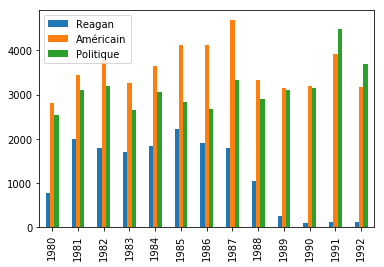

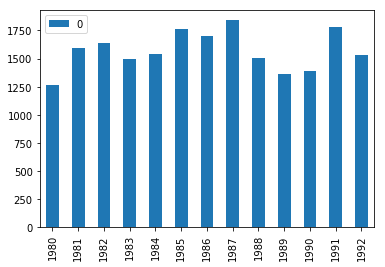

In [73]:
keywords = ["Reagan", "Etats-Unis", "USA ", "Amerique", "Washington", "politique", "économie", "pershing"]
corpus1, occ1, articlePerYear1 =read_archive(keywords)
dates = [1982, 1987, 1983, 1986, 1980, 1985, 1981, 1984, 1991, 1988, 1990,1989, 1992] # dates in this python folder

keys = ["Reagan", "Américain", "Politique"]
occ = concatOcc(keywords, keys, occ1)
plot_occurences(occ, keys, dates, "corpus1")
print("article per year:"  + str(articlePerYear1))
print("nb article total:" + str(len(corpus1)))
plot_nb_articles(articlePerYear1, dates, "corpus1_occ")

JDG-1982-reduced.jsonl.bz2
JDG-1987-reduced.jsonl.bz2
JDG-1983-reduced.jsonl.bz2
JDG-1986-reduced.jsonl.bz2
JDG-1980-reduced.jsonl.bz2
JDG-1985-reduced.jsonl.bz2
JDG-1981-reduced.jsonl.bz2
JDG-1984-reduced.jsonl.bz2
JDG-1991-reduced.jsonl.bz2
JDG-1988-reduced.jsonl.bz2
JDG-1990-reduced.jsonl.bz2
JDG-1989-reduced.jsonl.bz2
JDG-1992-reduced.jsonl.bz2
occurences per year (order see dates):[767, 1025, 684, 876, 869, 985, 827, 729, 1889, 951, 1478, 1195, 962]
nombre d'articles pour le corpus total:13237
article per year:[767, 1025, 684, 876, 869, 985, 827, 729, 1889, 951, 1478, 1195, 962]
nb article total:13237


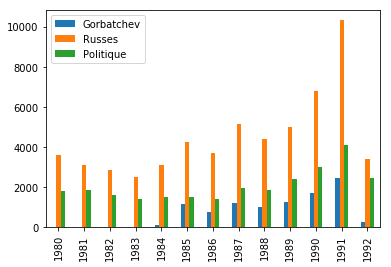

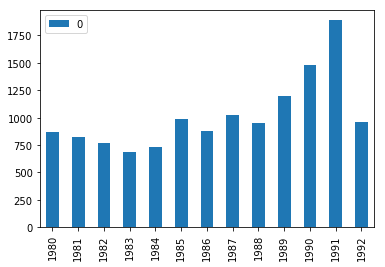

In [74]:
keywords = ["Gorbatchev", "Gorbatchov","Russie", "URSS", "Moscou", "soviétique","politique", "économie", "PCUS", "Perestroika", "Glasnot", "Glasnost"]
dates = [1982, 1987, 1983, 1986, 1980, 1985, 1981, 1984, 1991, 1988, 1990,1989, 1992] # dates in this python folder
corpus2, occ2, artPerYear2 = read_archive(keywords)

keys = ["Gorbatchev", "Russes", "Politique"]
occ = concatOcc(keywords, keys, occ2)
plot_occurences(occ, keys, dates, "corpus2")
print("nombre d'articles pour le corpus total:" + str(len(corpus2)))
print("article per year:"  + str(artPerYear2))
print("nb article total:" + str(len(corpus2)))
plot_nb_articles(artPerYear2, dates, "corpus2_occ")

In [18]:
print("article per year:"  + str(articlePerYear1))

article per year:[1640, 1841, 1498, 1697, 1267, 1759, 1593, 1538, 1781, 1504, 1387, 1362, 1528]


JDG-1982-reduced.jsonl.bz2
JDG-1987-reduced.jsonl.bz2
JDG-1983-reduced.jsonl.bz2
JDG-1986-reduced.jsonl.bz2
JDG-1980-reduced.jsonl.bz2
JDG-1985-reduced.jsonl.bz2
JDG-1981-reduced.jsonl.bz2
JDG-1984-reduced.jsonl.bz2
JDG-1991-reduced.jsonl.bz2
JDG-1988-reduced.jsonl.bz2
JDG-1990-reduced.jsonl.bz2
JDG-1989-reduced.jsonl.bz2
JDG-1992-reduced.jsonl.bz2
occurences per year (order see dates):[95, 247, 115, 217, 67, 484, 74, 86, 179, 183, 165, 218, 274]
article per year:[95, 247, 115, 217, 67, 484, 74, 86, 179, 183, 165, 218, 274]
nb article total:2404


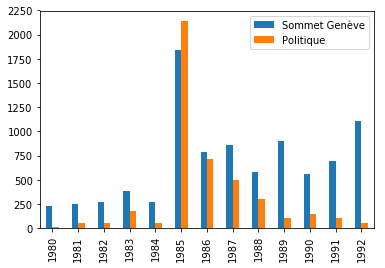

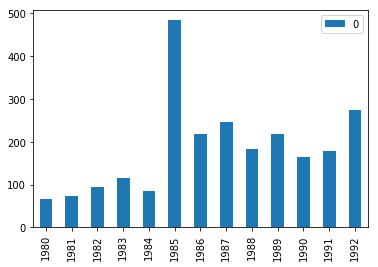

In [75]:
keywords = ["Sommet", "Genève", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]
corpus6, occ6, articlePerYear6 =read_archive(keywords)

keys = ["Sommet Genève", "Politique"]
occ = concatOcc(keywords, keys, occ3)
plot_occurences(occ, keys, dates, "corpus6")
print("article per year:"  + str(articlePerYear6))
print("nb article total:" + str(len(corpus6)))
plot_nb_articles(articlePerYear6, dates, "corpus6_occ")

JDG-1982-reduced.jsonl.bz2
JDG-1987-reduced.jsonl.bz2
JDG-1983-reduced.jsonl.bz2
JDG-1986-reduced.jsonl.bz2
JDG-1980-reduced.jsonl.bz2
JDG-1985-reduced.jsonl.bz2
JDG-1981-reduced.jsonl.bz2
JDG-1984-reduced.jsonl.bz2
JDG-1991-reduced.jsonl.bz2
JDG-1988-reduced.jsonl.bz2
JDG-1990-reduced.jsonl.bz2
JDG-1989-reduced.jsonl.bz2
JDG-1992-reduced.jsonl.bz2
occurences per year (order see dates):[97, 245, 60, 163, 68, 207, 100, 48, 115, 103, 151, 132, 80]
article per year:[97, 245, 60, 163, 68, 207, 100, 48, 115, 103, 151, 132, 80]
nb article total:1569


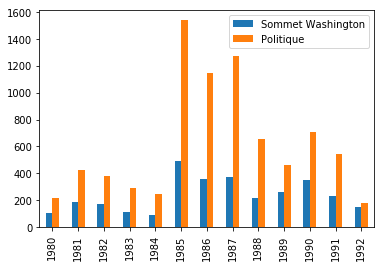

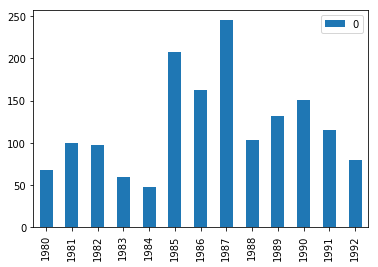

In [76]:
keywords = ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]
corpus7, occ7, articlePerYear7 =read_archive(keywords)

keys = ["Sommet Washington", "Politique"]
occ = concatOcc(keywords, keys, occ7)
plot_occurences(occ, keys, dates, "corpus7")
print("article per year:"  + str(articlePerYear7))
print("nb article total:" + str(len(corpus7)))
plot_nb_articles(articlePerYear7, dates, "corpus7_occ")

JDG-1982-reduced.jsonl.bz2
JDG-1987-reduced.jsonl.bz2
JDG-1983-reduced.jsonl.bz2
JDG-1986-reduced.jsonl.bz2
JDG-1980-reduced.jsonl.bz2
JDG-1985-reduced.jsonl.bz2
JDG-1981-reduced.jsonl.bz2
JDG-1984-reduced.jsonl.bz2
JDG-1991-reduced.jsonl.bz2
JDG-1988-reduced.jsonl.bz2
JDG-1990-reduced.jsonl.bz2
JDG-1989-reduced.jsonl.bz2
JDG-1992-reduced.jsonl.bz2
occurences per year (order see dates):[444, 478, 362, 482, 471, 642, 455, 391, 610, 379, 453, 351, 347]
article per year:[444, 478, 362, 482, 471, 642, 455, 391, 610, 379, 453, 351, 347]
nb article total:5865


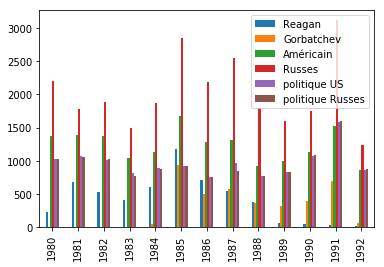

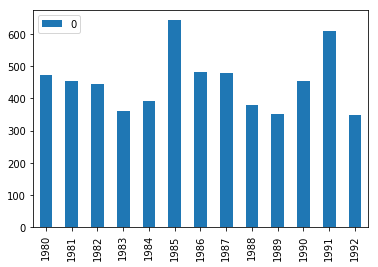

In [77]:
keywords = ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA ", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]

corpusOneAndTwo, occOneAndTwo, articlePerYearOneAndTwo = read_archive(keywords)

keys = ["Reagan", "Gorbatchev", "Américain", "Russes", "politique US", "politique Russes"]

occ = concatOcc(keywords, keys, occOneAndTwo)
plot_occurences(occ, keys, dates, "corpusOneAndTwo")
print("article per year:"  + str(articlePerYearOneAndTwo))
print("nb article total:" + str(len(corpusOneAndTwo)))
plot_nb_articles(articlePerYearOneAndTwo, dates, "corpusOneAndTwo_occ")

In [ ]:
keywords = ["Reagan", "Gorbatchev", "Gorbatchov", "Etats-Unis", "USA ", "Amérique", "Washington", "Russie", "URSS", "Moscou", "soviétique", "politique", "économie", "pershing", "politique", "économie", "PCUS", "Perestroika", "Glasnot"]

print([keywords[0]])
print(keywords[1:3])
print(keywords[3:7])
print(keywords[7:11])
print(keywords[11:14])
print(keywords[14:18])

keys = ["Reagan", "Gorbatchev", "Américain", "Russes", "politique US", "politique Russes"]




In [ ]:
for article in corpus4:
    json_article = json.loads(article)
    print(json_article["id"] + " " + json_article["fulltext"][0:50] + "\n\n")

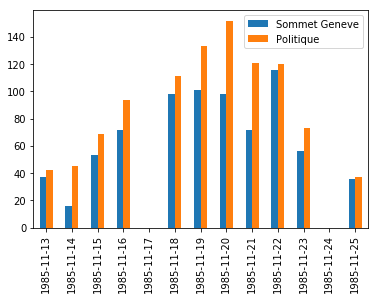

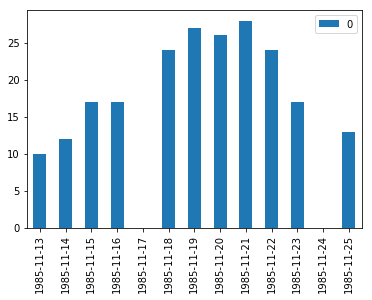

In [84]:
# corpus 6 bis on good dates

keywords = ["Sommet", "Genève", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]
#corpus6, occ6 =read_archive(keywords)

keys = ["Sommet Geneve", "Politique"]
#occ = concatOcc(keywords, keys, occ3)
#plot_occurences(occ, keys, dates, "corpus3bis")


path = "data/JDG-1985-reduced.jsonl.bz2"
f = BZ2File(path, 'r')
articles = list(read_jsonlines(f))

d1 = date(1985, 11, 13)
d2 = date(1985, 11, 25)
# dates = ["1985-11-13", "1985-11-25"]
dates = string_dates(d1, d2)
datesCorpus6bis = string_dates(d1, d2)


corpus6bis, occ6bis, num_article_per_day6bis = study_file(path, dates, keywords)

occ = concatOcc(keywords, keys, occ6bis)
plot_occurences(occ, keys, dates, "corpus6bis")
plot_nb_articles(num_article_per_day6bis, dates, "corpus6bis_occ")

#print(len(corpus6bis))

96
36041


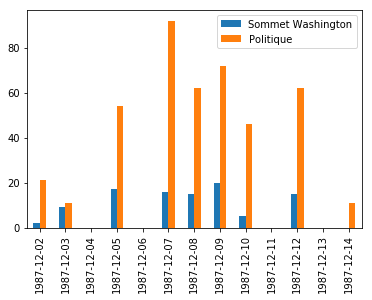

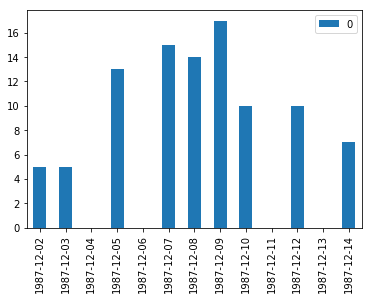

In [86]:
# corpus 7 bis on good dates

keywords = ["Sommet", "Washington", "Reagan", "Gorbatchev", "Gorbatchov", "Moscou", "Washington"]

#corpus3, occ3 =read_archive(keywords)

keys = ["Sommet Washington", "Politique"]
#occ = concatOcc(keywords, keys, occ3)
#plot_occurences(occ, keys, dates, "corpus3bis")


path = "data/JDG-1987-reduced.jsonl.bz2"
f = BZ2File(path, 'r')
articles = list(read_jsonlines(f))

d1 = date(1987, 12, 2)
d2 = date(1987, 12, 14)
# dates = ["1987-12-02", "1987-12-14"]
dates = string_dates(d1, d2)


corpus7bis, occ7bis, num_article_per_day7bis = study_file(path, dates, keywords)

occ = concatOcc(keywords, keys, occ7bis)
plot_occurences(occ, keys, dates, "corpus7bis")

plot_nb_articles(num_article_per_day7bis, dates, "corpus7bis_occ")

print(len(corpus7bis))
print(len(articles))

In [79]:
def study_file(filepath, dates, keywords):
    f = BZ2File(path, 'r')
    articles = list(read_jsonlines(f))
    # print("ENTER FUNCTION...")
    selected_articles = []
    ALLOCC = []
    num_article_on_dates = []
    for date in dates:
        num_article_on_one_date = 0
        occALLArticleOneDate = np.asarray([0] * len(keywords))
        
        for article in articles:
            json_article = json.loads(article)
            infos = json_article["id"]
            # print(infos)
            if str(date) in infos:
                if(isValid(json_article)):
                    
                    selected, occurences = isSelected(json_article, keywords)
                    
                    if(selected):
                        # append to the return articles
                        selected_articles.append(article)
                        # add one to the count of article that are selected on one date
                        num_article_on_one_date += 1 # here we can append the article and append the len() of it : num_article_on_dates.append(len(num_article_on_one_date)
                        # add the occurences
                        occALLArticleOneDate += occurences
                        
        num_article_on_dates.append(num_article_on_one_date)

        ALLOCC.append(occALLArticleOneDate)
        
    return selected_articles, np.asarray(ALLOCC), num_article_on_dates
        
    

In [ ]:
for article in articles:
        json_article = json.loads(article)
        infos = json_article["id"]

        for date in dates:
            if str(date) in infos:
                if(isValid(json_article)):
                    selected, occurences = isSelected(json_article, keywords)
                    
                    if(selected):
                        # append to the return articles
                        selected_articles.append(article)
                        # add the occurences
                        occALLArticleOneArchive += occurences

    

In [ ]:
print(len(corpus1))
print(len(corpus2))
print(len(corpus6))
print(len(corpus7))
print(len(corpusOneAndTwo))
print(len(corpus6bis))
print(len(corpus7bis))



In [ ]:
i =0 
for article in corpus4bis:
    json_article = json.loads(article)
    print(str(i) + " - " + json_article["id"][6:14] + " "+ json_article["fulltext"][0:50])
    i += 1
    
print(i)



In [ ]:
json_article = json.loads(corpus4bis[241])

json_article["fulltext"]

In [ ]:
i = 0
path = "data/JDG-1987-reduced.jsonl.bz2"
f = BZ2File(path, 'r')
checkArticlesArchive = list(read_jsonlines(f))
len(articles)

strCheck = ""

for article in checkArticlesArchive:
    json_article = json.loads(article)
    infos = json_article["id"]
    if str("1987-12-12") in infos:
        print(str(i) + " - " + json_article["id"][6:14] + " "+ json_article["fulltext"][0:50])
        
        if ( json_article["fulltext"][0:50] == "LA FIN DU SOMMET DE WASHINGTON Un traité et beauco"):
            print("\n\n\n\n\n")
        i += 1
    
print(i)

In [ ]:
d1 = date(1987, 12, 2)
d2 = date(1987, 12, 14)
# dates = ["1987-12-02", "1987-12-14"]
dates = string_dates(d1, d2)

print(dates)
print(len(dates))




i = 0
path = "data/JDG-1987-reduced.jsonl.bz2"
f = BZ2File(path, 'r')
checkArticlesArchive = list(read_jsonlines(f))
len(articles)

strCheck = ""

for article in checkArticlesArchive:
    json_article = json.loads(article)
    infos = json_article["id"]
    for date in dates:
        if( str(date) in infos ):
            if ( json_article["fulltext"][0:50] == "LA FIN DU SOMMET DE WASHINGTON Un traité et beauco"):
                print( str(date) + " " + infos)
            
    #if str("1987-12-12") in infos:
    #    print(str(i) + " - " + json_article["id"][6:14] + " "+ json_article["fulltext"][0:50])
        
    #    if ( json_article["fulltext"][0:50] == "LA FIN DU SOMMET DE WASHINGTON Un traité et beauco"):
    #        print("\n\n\n\n\n")
    #    i += 1
    
print(i)


In [ ]:
for date in dates:
    print("----" + str(date))
    if (str(date) in json_article["id"]):
        print(str(date))

In [ ]:
print(json_article["id"])

In [ ]:
for article in corpus3bis:
    print(article)

In [ ]:
print(len(corpus6bis))

In [78]:
k = ["Reagan", "Etats-Unis", "USA ", "Amerique", "Washington", "politique", "économie", "pershing"]

for article in corpus3bis:
    json_article = json.loads(article)
    print(str(isSelected(json_article, k)) + " " +  json_article["fulltext"])
    
    # print("\n")
    # print les articles et faire cmd + f 

(True, array([2, 0, 0, 0, 0, 0, 0, 0])) Télévision romande : un déploiement sans précédent SOMMET REAGAN-GORBATCHEV Quelque 42 chaînes de télévision du monde entier ont demandé l'aide de la Télévision romande pour cette opération qualifiée de « sans précédent » SOMMET DEGENÈVE Selon ses estimations, la Télévision suisse romande dépensera environ un million de francs suisses afin de mener à bien sa mission dans le cadre de la rencontre américaine. Mission qui ne consistera pas seulement à informer le public, mais aussi à appuyer les quelque 42 chaînes de télévision du globe, qui ont demandé aide à la RTSR. 19-20 NOVEMBRE 85 Pour cette opération qualifiée de « sans précédent » (la RTSR espère un coup de pouce financier de la Confédération), des cars de reportages seront détachés en neuf points stratégiques ; ils seront en liaison permanente avec les studios TV par faisceaux hertziens mobiles. Les images retransmises au Centre international de conférences, quartier général de la presse, p

In [81]:
from datetime import date, timedelta
# code pour drop les articles inutiles dans corpus 1:
# 20 janvier 1981 au 20 janvier 1989
# on va faire de 81 à 1988
# 20 jours en 1989
corpus1cleaned = []

d1 = date(1989, 1, 1)
d2 = date(1989, 1, 20)
dates89 = string_dates(d1, d2)

d1 = date(1981, 1, 1)
d2 = date(1981, 1, 19) # ignore only until 19th
dates81 = string_dates(d1, d2)

for article in corpus1:
    json_article = json.loads(article)
    infos = json_article["id"]
    # chosen to put in or condition to have a better performance than for loop
    if ("1982" in infos or "1983" in infos or "1984" in infos or "1985" in infos or "1986" in infos or "1987" in infos or "1988" in infos):
        corpus1cleaned.append(article)
    elif("1989" in infos):
        for date in dates89:
            if(str(date) in infos):
                corpus1cleaned.append(article)
                break;
    elif ("1981" in infos): # ignoring from 1st january to 21 1981
        for date in dates81:
            if(not(str(date) in infos)):
                corpus1cleaned.append(article)
                break;

print("Le nombre d'article pour le corpus 1 complètement nettoyé est de " + str(len(corpus1cleaned)) + " articles.")
    
from datetime import date, timedelta
# code pour drop les articles inutiles dans corpus 2:
#  11 mars 1985 au 24 août 1991
d1 = date(1985, 1, 1)
d2 = date(1985, 3, 10)
dates85 = string_dates(d1, d2)

d1 = date(1991, 1, 1)
d2 = date(1991, 8, 24)
dates91 = string_dates(d1, d2)
#if str(date) in infos:


corpus2cleaned = []

for article in corpus2:
    json_article = json.loads(article)
    infos = json_article["id"]
    # chosen to put in or condition to have a better performance than for loop
    if ("1986" in infos or "1987" in infos or "1988" in infos or "1989" in infos or "1990" in infos):
        corpus2cleaned.append(article)
    elif("1991" in infos):
        for date in dates91:
            if(str(date) in infos):
                corpus2cleaned.append(article)
                break;
    elif ("1985" in infos): # ignoring 
        for date in dates85:
            if(not(str(date) in infos)):
                corpus2cleaned.append(article)
                break;


print("Le nombre d'article pour le corpus 2 complètement nettoyé est de " + str(len(corpus2cleaned)) + " articles.")
  

Le nombre d'article pour le corpus 1 complètement nettoyé est de 13162 articles.
Le nombre d'article pour le corpus 2 complètement nettoyé est de 7667 articles.


In [53]:
print(len(corpus1))
print(len(corpus2))
print(len(corpus3))
print(len(corpus4))
print(len(corpusOneAndTwo))
#print(len(corpus6bis))
#print(len(corpus7bis))
print("Le nombre d'article pour le corpus 1 complètement nettoyé est de " + str(len(corpus1cleaned)) + " articles.")
print("Le nombre d'article pour le corpus 2 complètement nettoyé est de " + str(len(corpus2cleaned)) + " articles.")
  

20395
13237
2404
1569
5865
Le nombre d'article pour le corpus 1 complètement nettoyé est de 13162 articles.
Le nombre d'article pour le corpus 2 complètement nettoyé est de 7667 articles.


In [32]:
from datetime import date, timedelta
d1 = date(1981, 1, 1)

In [49]:
print(articlePerYear1)
print(artPerYear2)

dates = [1982, 1987, 1983, 1986, 1980, 1985, 1981, 1984, 1991, 1988, 1990,1989, 1992] # dates in this python folder



[1640, 1841, 1498, 1697, 1267, 1759, 1593, 1538, 1781, 1504, 1387, 1362, 1528]
[767, 1025, 684, 876, 869, 985, 827, 729, 1889, 951, 1478, 1195, 962]


In [50]:
df = pd.DataFrame(articlePerYear1, dates).sort_index()

In [51]:
print(df)


         0
1980  1267
1981  1593
1982  1640
1983  1498
1984  1538
1985  1759
1986  1697
1987  1841
1988  1504
1989  1362
1990  1387
1991  1781
1992  1528


In [52]:
# 20 janvier 1981 au 20 janvier 1989
s = 1267 + 1593 + 1640 + 1498 + 1538 + 1759 + 1697 + 1841 +1504

print(s)

14337


In [60]:
# This takes the corpusOneAndTwo and computes the corpus3, corpus4 and corpus5

# corpus 3 = 1981 à 1984
corpus3 = []

# corpus 4 = 1985 à 1988
corpus4 = []


# corpus 5 = 1989 à 1991
corpus5 = []

for article in corpusOneAndTwo:
    json_article = json.loads(article)
    infos = json_article["id"]
    if ("1981" in infos or "1982" in infos or "1983" in infos or "1984" in infos):
        corpus3.append(article)
    elif("1985" in infos or "1986" in infos or "1987" in infos or "1988" in infos):
        corpus4.append(article)
    elif("1989" in infos or "1990" in infos or "1991" in infos):
        corpus5.append(article)

print("Le nombre d'article pour le corpus 1 intersection 2 (sur la période de 1980 à 1992) complètement nettoyé est de " + str(len(corpusOneAndTwo)) + " articles.")
print("Le nombre d'article pour le corpus 3 complètement nettoyé est de " + str(len(corpus3)) + " articles.")
print("Le nombre d'article pour le corpus 4 complètement nettoyé est de " + str(len(corpus4)) + " articles.")
print("Le nombre d'article pour le corpus 5 complètement nettoyé est de " + str(len(corpus5)) + " articles.")




Le nombre d'article pour le corpus 1 intersection 2 (sur la période de 1980 à 1992) complètement nettoyé est de 5865 articles.
Le nombre d'article pour le corpus 3 complètement nettoyé est de 1652 articles.
Le nombre d'article pour le corpus 4 complètement nettoyé est de 1981 articles.
Le nombre d'article pour le corpus 5 complètement nettoyé est de 1414 articles.


In [59]:
# function inspired from Group E code (https://github.com/RomainMendez/Digital-Humanities-Project/blob/master/src/filterdata.py)

def save_corpus(articles, filename):
    f = open(filename + ".txt", "a+")
    for article in articles:
        json_article = json.loads(article)
        f.write("**** *" + json_article["date"] + "\n" + json_article["fulltext"] + "\n")
        
save_corpus(corpus5, "salut")
    

In [87]:
save_corpus(corpus1cleaned, "corpus1")
save_corpus(corpus2cleaned, "corpus2")
save_corpus(corpus3, "corpus3")
save_corpus(corpus4, "corpus4")
save_corpus(corpus5, "corpus5")
save_corpus(corpus6, "corpus6")
save_corpus(corpus7, "corpus7")

print("Le nombre d'article pour le corpus 1 complètement nettoyé est de " + str(len(corpus1cleaned)) + " articles.")
print("Le nombre d'article pour le corpus 2 complètement nettoyé est de " + str(len(corpus2cleaned)) + " articles.")
print("Le nombre d'article pour le corpus 1 intersection 2 (sur la période de 1980 à 1992) complètement nettoyé est de " + str(len(corpusOneAndTwo)) + " articles.")
print("Le nombre d'article pour le corpus 3 complètement nettoyé est de " + str(len(corpus3)) + " articles.")
print("Le nombre d'article pour le corpus 4 complètement nettoyé est de " + str(len(corpus4)) + " articles.")
print("Le nombre d'article pour le corpus 5 complètement nettoyé est de " + str(len(corpus5)) + " articles.")
print("Le nombre d'article pour le corpus 6 complètement nettoyé est de " + str(len(corpus6)) + " articles.")
print("Le nombre d'article pour le corpus 7 complètement nettoyé est de " + str(len(corpus7)) + " articles.")





Le nombre d'article pour le corpus 1 complètement nettoyé est de 13162 articles.
Le nombre d'article pour le corpus 2 complètement nettoyé est de 7667 articles.
Le nombre d'article pour le corpus 1 intersection 2 (sur la période de 1980 à 1992) complètement nettoyé est de 5865 articles.
Le nombre d'article pour le corpus 3 complètement nettoyé est de 1652 articles.
Le nombre d'article pour le corpus 4 complètement nettoyé est de 1981 articles.
Le nombre d'article pour le corpus 5 complètement nettoyé est de 1414 articles.
Le nombre d'article pour le corpus 6 complètement nettoyé est de 2404 articles.
Le nombre d'article pour le corpus 7 complètement nettoyé est de 1569 articles.
